#### Vision Transformers Explained Series

# Vision Transformers, Explained

### A Full Walk-Through of Vision Transformers in PyTorch

*Since their introduction in 2017 with* Attention is All You Need¹, *transformers have established themselves as the state of the art for natural language processing (NLP). In 2021,* An Image is Worth 16x16 Words *successfully adapted transformers for computer vision tasks. Since then, numerous transformer-based architectures have been proposed for computer vision.*

**This article walks through the Vision Transformer (ViT) as laid out in _An Image is Worth 16x16 Words_ ². It includes open-source code for the ViT, as well as conceptual explanations of the components. All of the code uses the PyTorch Python package.**

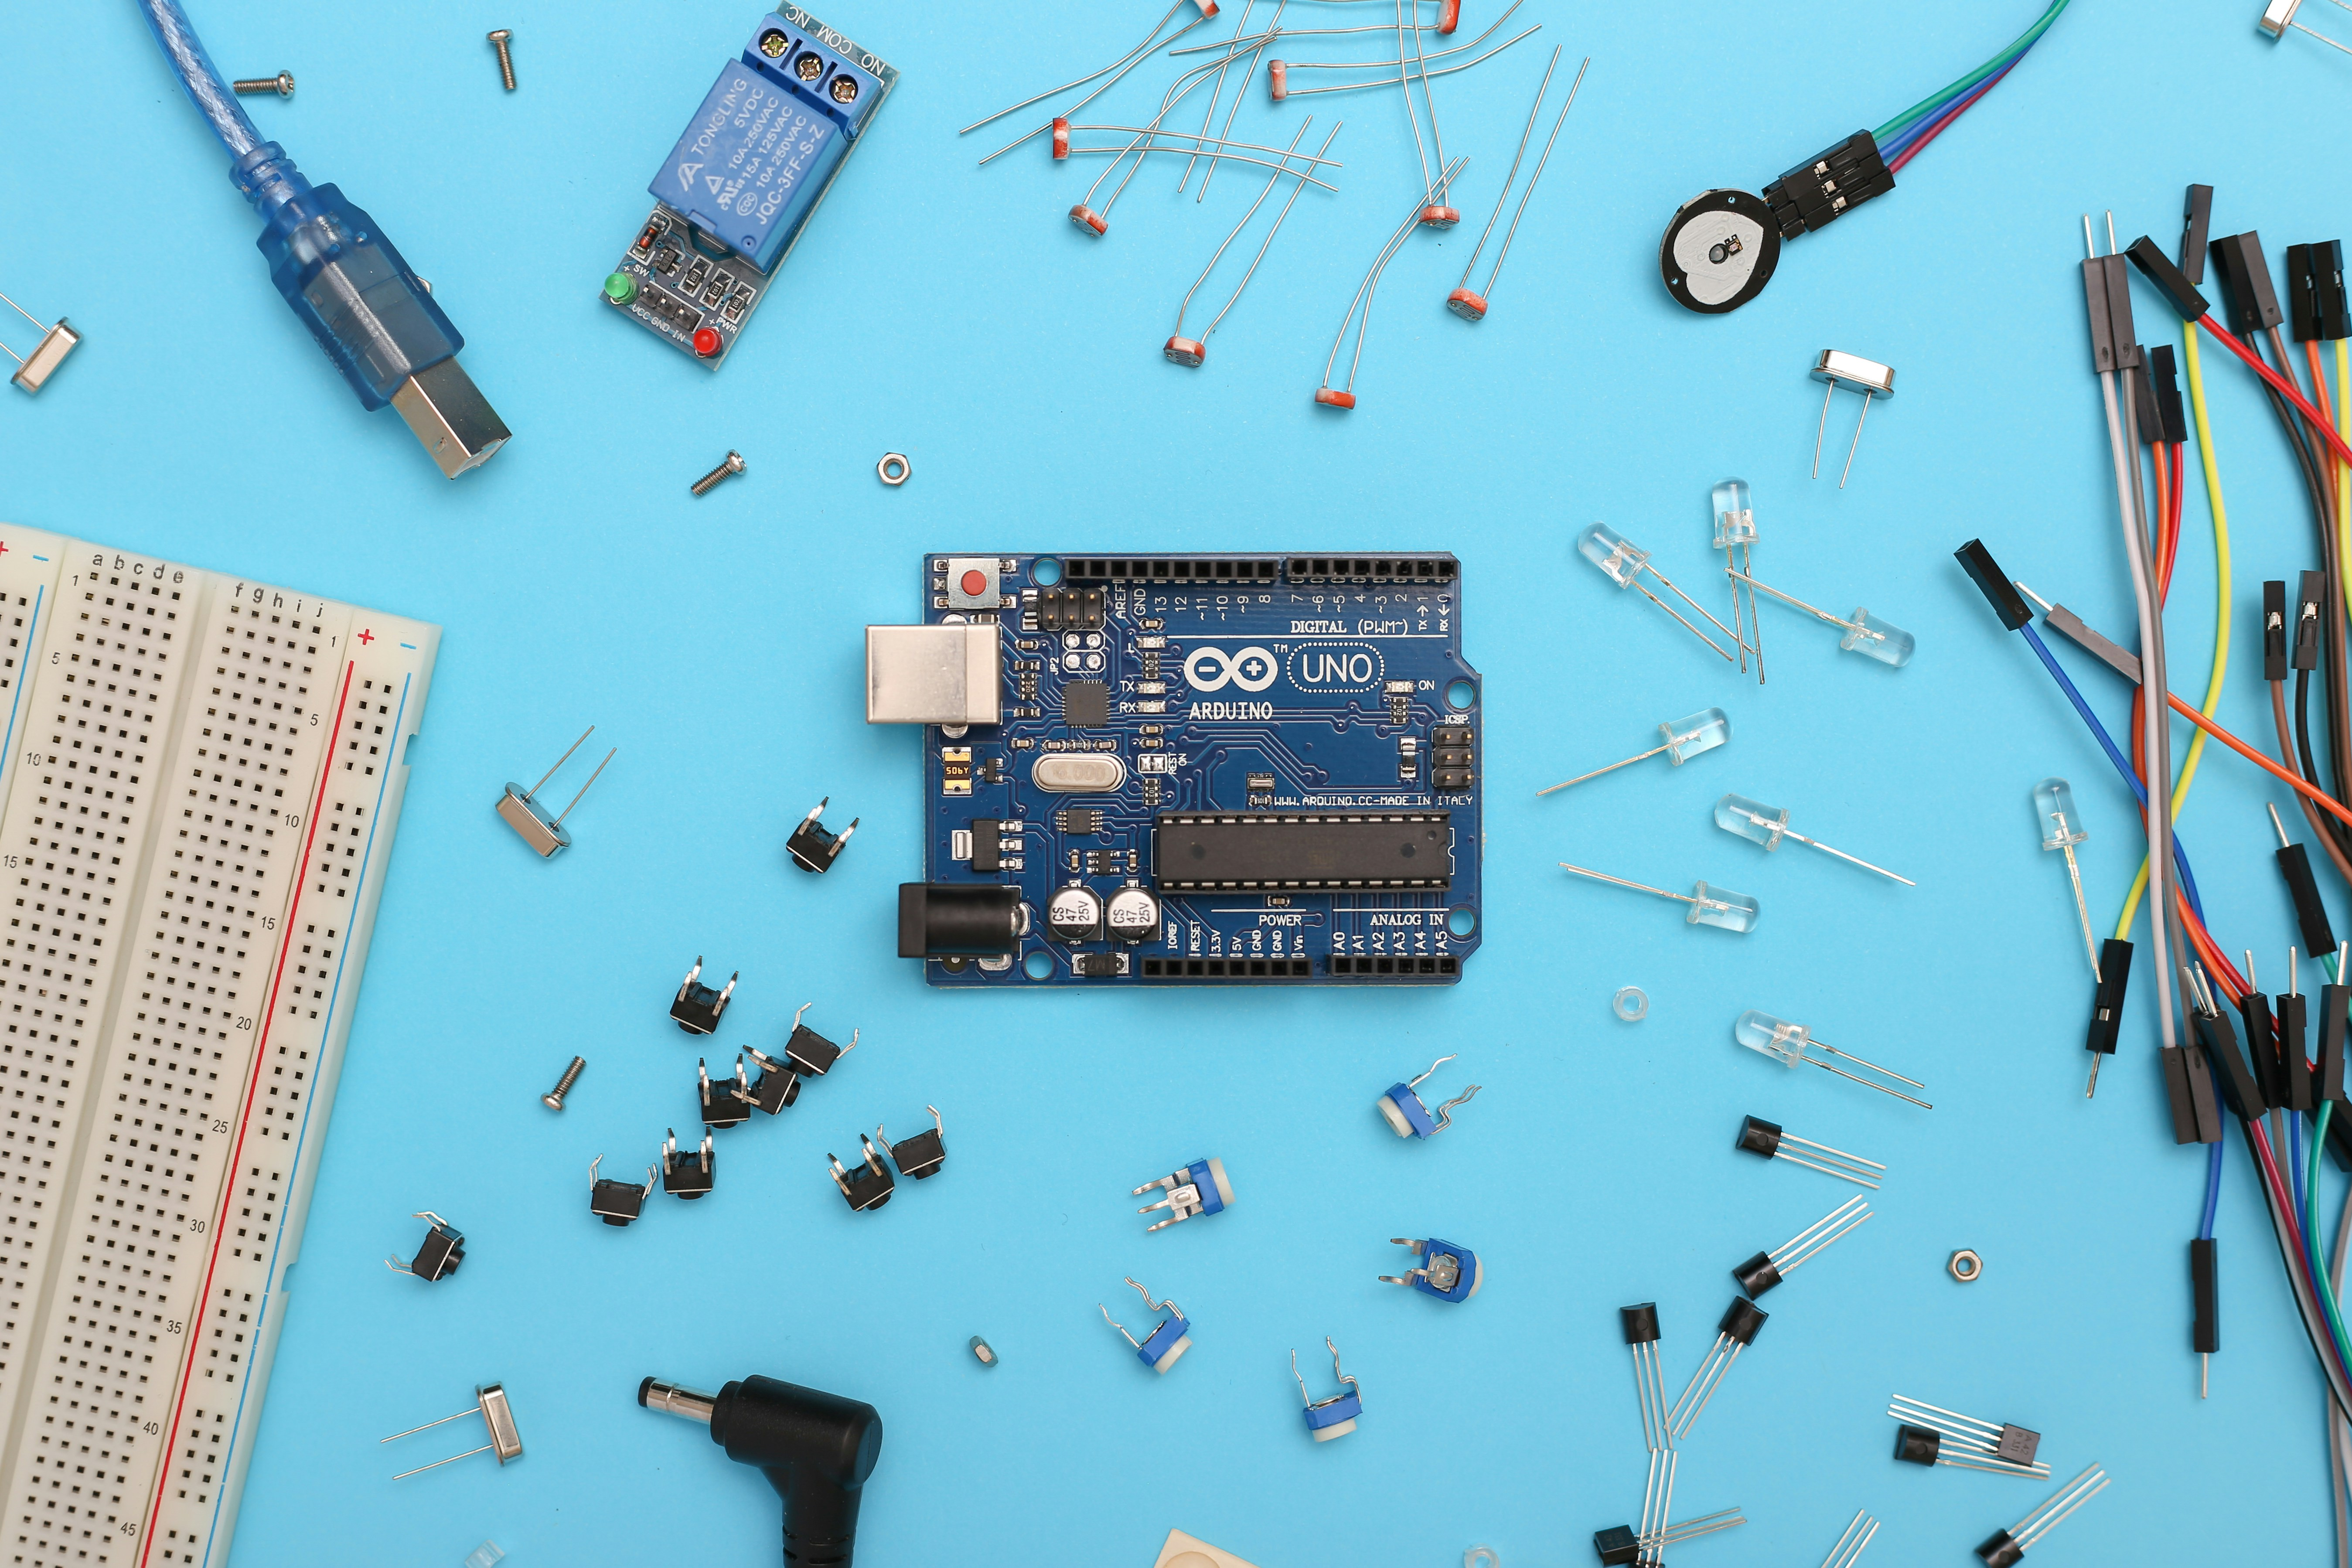
Photo by <a href="https://unsplash.com/@sahandbabali?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Sahand Babali</a> on <a href="https://unsplash.com/photos/blue-and-black-circuit-board-owjrvbyXYyc?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>
  

This article is part of a collection examining the internal workings of Vision Transformers in depth. Each of these articles is also available as a Jupyter Notebook with executable code. The other articles in the series are:

 - [Vision Transformers, Explained](https://towardsdatascience.com/vision-transformers-explained-a9d07147e4c8)
    - [**Jupyter Notebook**](https://github.com/lanl/vision_transformers_explained/blob/main/notebooks/VisionTransformersExplained.ipynb)
 - [Attention for Vision Transformers, Explained](https://towardsdatascience.com/attention-for-vision-transformers-explained-70f83984c673)
    - [Jupyter Notebook](https://github.com/lanl/vision_transformers_explained/blob/main/notebooks/AttentionExplained.ipynb)
 - [Position Embeddings for Vision Transformers, Explained](https://towardsdatascience.com/position-embeddings-for-vision-transformers-explained-a6f9add341d5)
    - [Jupyter Notebook](https://github.com/lanl/vision_transformers_explained/blob/main/notebooks/PositionEmbeddingExplained.ipynb)
 - [Tokens-to-Token Vision Transformers, Explained](https://towardsdatascience.com/tokens-to-token-vision-transformers-explained-2fa4e2002daa)
    - [Jupyter Notebook](https://github.com/lanl/vision_transformers_explained/blob/main/notebooks/TokensToTokenViTExplained.ipynb)
 - [GitHub Repository](https://github.com/lanl/vision_transformers_explained) for Vision Transformers, Explained Series

In [1]:
import os
import copy
import math
import typing
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import timm.layers as timmm 

In [2]:
figure_path = '../figures/NotebookOutput'

In [3]:
NoneFloat = typing.Union[None, float]

## What are Vision Transformers?

As introduced in *Attention is All You Need*¹, transformers are a type of machine learning model utilizing attention as the primary learning mechanism. Transformers quickly became the state of the art for sequence-to-sequence tasks such as language translation.

An *Image is Worth 16x16 Words*² successfully modified the transformer put forth in [1] to solve image classification tasks, creating the Vision Transformer (ViT). The ViT is based on the same attention mechanism as the transformer in [1]. However, while transformers for NLP tasks consist of an encoder attention branch and a decoder attention branch, the ViT only uses an encoder. The output of the encoder is then passed to a neural network "head" that makes a prediction.

The drawback of ViT as implemented in [2] is that it's optimal performance requires pretraining on large datasets. The best models pretrained on the proprietary JFT-300M dataset. Models pretrained on the smaller, open source ImageNet-21k perform on par with the state-of-the-art convolutional ResNet models. 

*Tokens-to-Token ViT: Training Vision Transformers from Scratch on ImageNet*³ attempts to remove this pretraining requirement by introducing a novel pre-processing methodology to transform an input image into a series of tokens. More about this method can be found [here](https://towardsdatascience.com/tokens-to-token-vision-transformers-explained-2fa4e2002daa). For this article, we'll focus on the ViT as implemented in [2].

## Model Walk-Through

This article follows the model structure outlined in *An Image is Worth 16x16 Words*². However, code from this paper is not publicly available. Code from the more recent *Tokens-to-Token ViT*³ is available on GitHub. The Tokens-to-Token ViT (T2T-ViT) model prepends a Tokens-to-Token (T2T) module to a vanilla ViT backbone. The code in this article is based on the ViT components in the *Tokens-to-Token ViT*³ GitHub code. Modifications made for this article include, but are not limited to, modifying to allow for non-square input images and removing dropout layers.

A diagram of the ViT model is shown below.

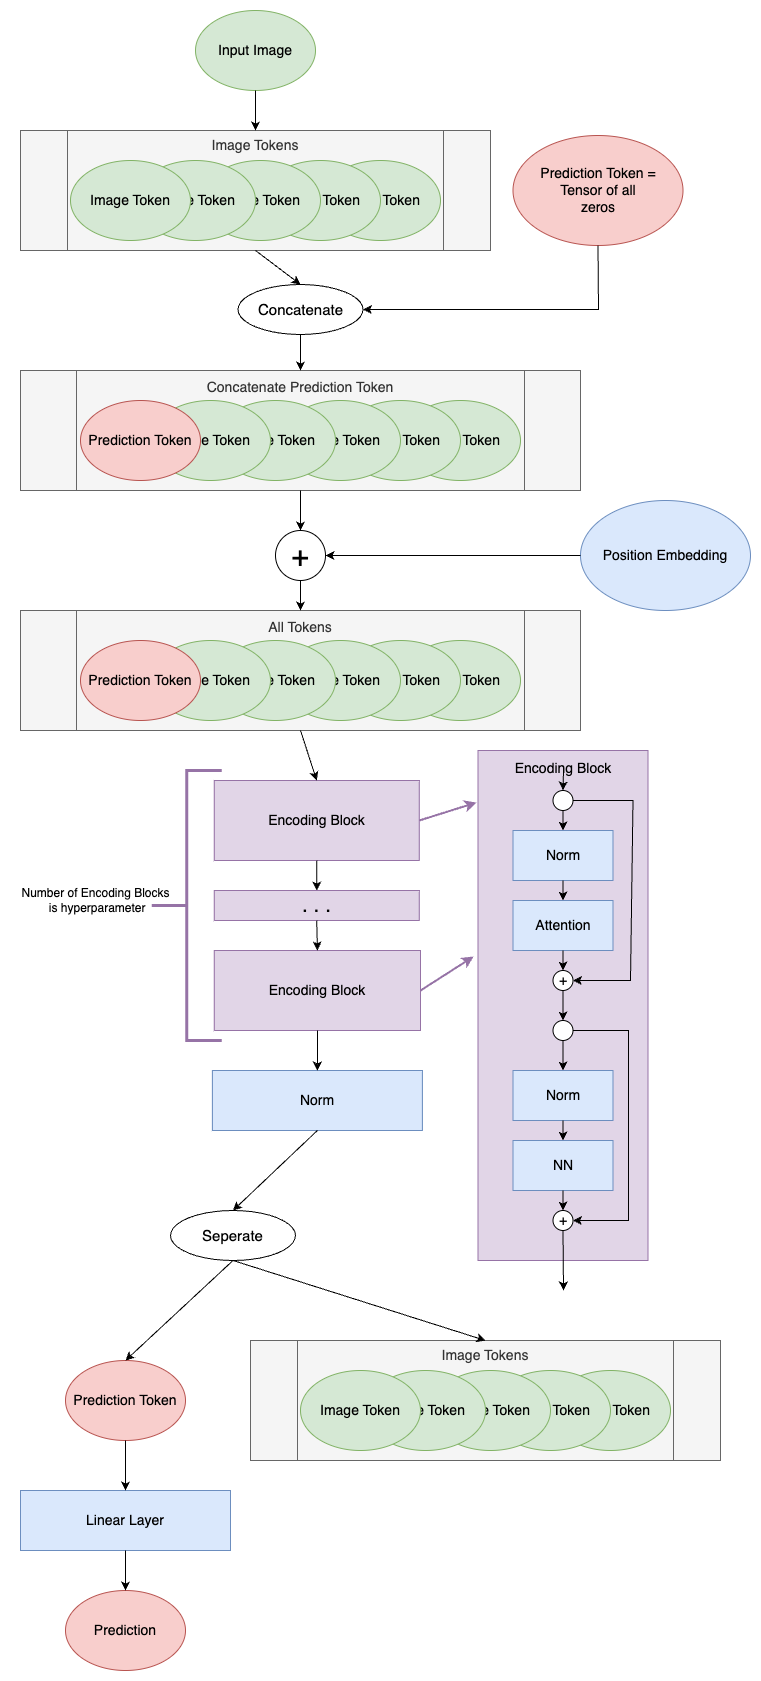

### Image Tokenization

The first step of the ViT is to create tokens from the input image. Transformers operate on a *sequence* of *tokens*; in NLP, this is commonly a *sentence* of *words*. For computer vision, it is less clear how to segment the input into tokens. 

The ViT converts an image to tokens such that each token represents a local area - or *patch* - of the image. They describe reshaping an image of height $H$, width $W$, and channels $C$ into $N$ tokens with patch size $P$:

$$ N = \frac{HW}{P^2}$$

Each token is of length $P^2*C$.

Let's look at an example of patch tokenization on this pixel art *Mountain at Dusk* by Luis Zuno (@ansimuz)⁴. The original artwork has been cropped and converted to a single channel image. This means that each pixel has a value between zero and one. Single channel images are typically displayed in grayscale; however, we'll be displaying it in a purple color scheme because its easier to see.

Note that the patch tokenization is not included in the code associated with [3]. All code in this section is original to the author.

Mountain at Dusk is H = 60 and W = 100 pixels.




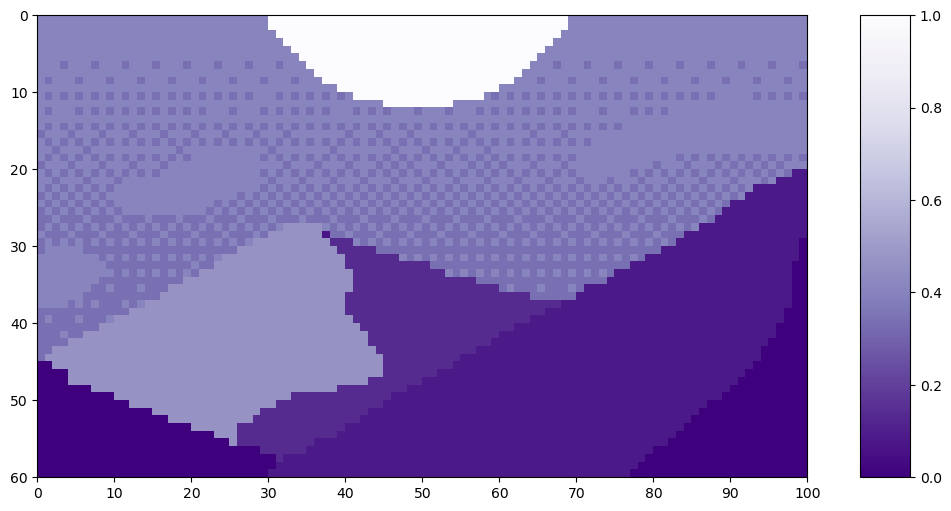

In [4]:
mountains = np.load(os.path.join(figure_path, 'mountains.npy'))

H = mountains.shape[0]
W = mountains.shape[1]
print('Mountain at Dusk is H =', H, 'and W =', W, 'pixels.')
print('\n')

fig = plt.figure(figsize=(10,6))
plt.imshow(mountains, cmap='Purples_r')
plt.xticks(np.arange(-0.5, W+1, 10), labels=np.arange(0, W+1, 10))
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
plt.clim([0,1])
cbar_ax = fig.add_axes([0.95, .11, 0.05, 0.77])
plt.clim([0, 1])
plt.colorbar(cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'mountains.png'), bbox_inches='tight')

This image has $H=60$ and $W=100$. We'll set $P=20$ since it divides both $H$ and $W$ evenly.

There will be 15 patches, each 20 by 20.




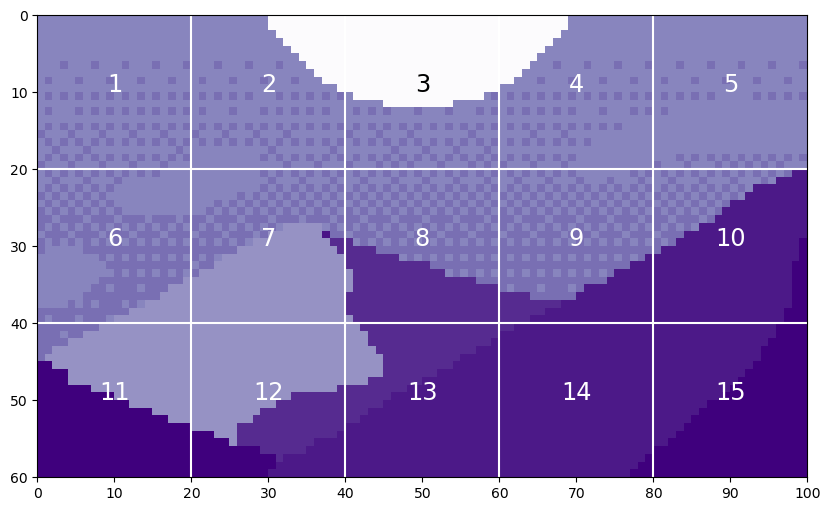

In [5]:
P = 20
N = int((H*W)/(P**2))
print('There will be', N, 'patches, each', P, 'by', str(P)+'.')
print('\n')

fig = plt.figure(figsize=(10,6))
plt.imshow(mountains, cmap='Purples_r')
plt.clim([0,1])
plt.hlines(np.arange(P, H, P)-0.5, -0.5, W-0.5, color='w')
plt.vlines(np.arange(P, W, P)-0.5, -0.5, H-0.5, color='w')
plt.xticks(np.arange(-0.5, W+1, 10), labels=np.arange(0, W+1, 10))
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
x_text = np.tile(np.arange(9.5, W, P), 3)
y_text = np.repeat(np.arange(9.5, H, P), 5)
for i in range(1, N+1):
    plt.text(x_text[i-1], y_text[i-1], str(i), color='w', fontsize='xx-large', ha='center')
plt.text(x_text[2], y_text[2], str(3), color='k', fontsize='xx-large', ha='center');
#plt.savefig(os.path.join(figure_path, 'mountain_patches.png'), bbox_inches='tight')

By flattening these patches, we see the resulting tokens. Let's look at patch 6 as an example.

Each patch will make a token of length 400.




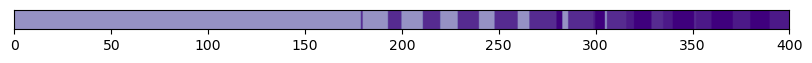

In [6]:
print('Each patch will make a token of length', str(P**2)+'.')
print('\n')

patch12 = mountains[40:60, 20:40]
token12 = patch12.reshape(1, P**2)

fig = plt.figure(figsize=(10,1))
plt.imshow(token12, aspect=10, cmap='Purples_r')
plt.clim([0,1])
plt.xticks(np.arange(-0.5, 401, 50), labels=np.arange(0, 401, 50))
plt.yticks([]);
#plt.savefig(os.path.join(figure_path, 'mountain_token12.png'), bbox_inches='tight')

After extracting tokens from an image, it is common to use a linear projection to change the length of the tokens. This is implemented as a learnable linear layer. The new length of the tokens is referred to as the *latent dimension*², *channel dimension*³, or the *token length*. After the projection, the tokens are no longer visually identifiable as a patch from the original image.

Now that we understand the concept, we can look at how patch tokenization is implemented in code.

In [7]:
class Patch_Tokenization(nn.Module):
    def __init__(self,
                img_size: tuple[int, int, int]=(1, 1, 60, 100),
                patch_size: int=50,
                token_len: int=768):

        """ Patch Tokenization Module
            Args:
                img_size (tuple[int, int, int]): size of input (channels, height, width)
                patch_size (int): the side length of a square patch
                token_len (int): desired length of an output token
        """
        super().__init__()
        
        ## Defining Parameters
        self.img_size = img_size
        C, H, W = self.img_size
        self.patch_size = patch_size
        self.token_len = token_len
        assert H % self.patch_size == 0, 'Height of image must be evenly divisible by patch size.'
        assert W % self.patch_size == 0, 'Width of image must be evenly divisible by patch size.'
        self.num_tokens = (H / self.patch_size) * (W / self.patch_size)

        ## Defining Layers
        self.split = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size, padding=0)
        self.project = nn.Linear((self.patch_size**2)*C, token_len)

    def forward(self, x):
        x = self.split(x).transpose(1,0)
        x = self.project(x)
        return x

Note the two assert statements that ensure the image dimensions are evenly divisible by the patch size. The actual splitting into patches is implemented as a `torch.nn.Unfold`⁵ layer.

We'll run an example of this code using our cropped, single channel version of *Mountain at Dusk*⁴. We should see the values for number of tokens and initial token size as we did above. We'll use *token_len=768* as the projected length, which is the size for the base variant of ViT².

The first line in the code block below is changing the datatype of *Mountain at Dusk*⁴ from a NumPy array to a Torch tensor. We also have to `unsqueeze`⁶ the tensor to create a channel dimension and a batch size dimension. As above, we have one channel. Since there is only one image, *batchsize=1*.

In [8]:
x = torch.from_numpy(mountains).unsqueeze(0).unsqueeze(0).to(torch.float32)
token_len = 768
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of input channels:', x.shape[1], '\n\timage size:', (x.shape[2], x.shape[3]))

# Define the Module
patch_tokens = Patch_Tokenization(img_size=(x.shape[1], x.shape[2], x.shape[3]),
                                    patch_size = P,
                                    token_len = token_len)

Input dimensions are
	batchsize: 1 
	number of input channels: 1 
	image size: (60, 100)


Now, we'll split the image into tokens.

In [9]:
x = patch_tokens.split(x).transpose(2,1)
print('After patch tokenization, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

After patch tokenization, dimensions are
	batchsize: 1 
	number of tokens: 15 
	token length: 400


As we saw in the example, there are *N=15* tokens each of length 400. Lastly, we project the tokens to be the *token_len*.

In [10]:
x = patch_tokens.project(x)
print('After projection, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

After projection, dimensions are
	batchsize: 1 
	number of tokens: 15 
	token length: 768


Now that we have tokens, we're ready to proceed through the ViT.

### Token Processing

We'll designate the next two steps of the ViT, before the encoding blocks, as "token processing." The token processing component of the ViT diagram is shown below.

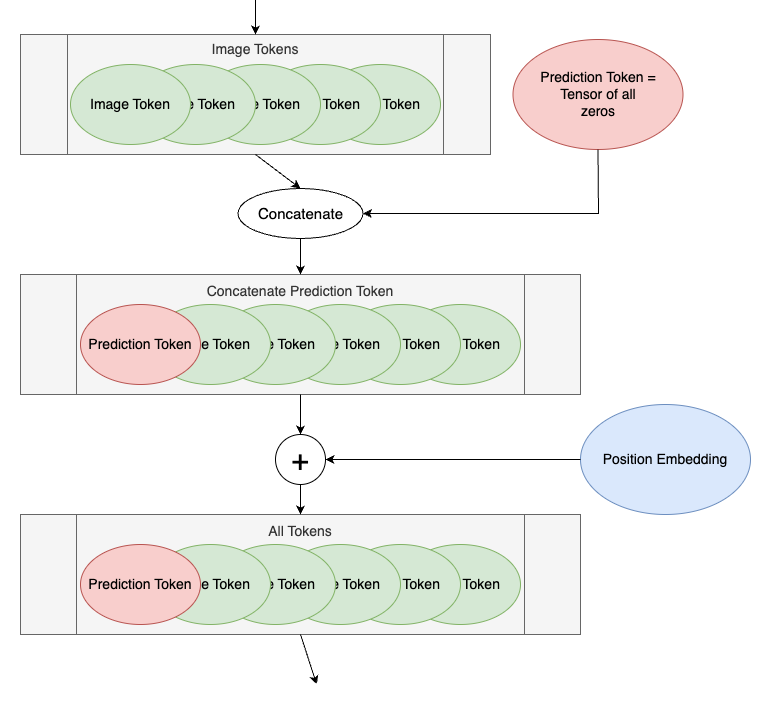

The first step is to prepend a blank token, called the *Prediction Token*, to the the image tokens. This token will be used at the output of the encoding blocks to make a prediction. It starts off blank - equivalently zero - so that it can gain information from the other image tokens.

We'll be starting with 175 tokens. Each token has length 768, which is the size for the base variant of ViT². We're using a batch size of 13 because it's prime and won't be confused for any of the other parameters.

In [11]:
# Define an Input
num_tokens = 175
token_len = 768
batch = 13
x = torch.rand(batch, num_tokens, token_len)
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

# Append a Prediction Token
pred_token = torch.zeros(1, 1, token_len).expand(batch, -1, -1)
print('Prediction Token dimensions are\n\tbatchsize:', pred_token.shape[0], '\n\tnumber of tokens:', pred_token.shape[1], '\n\ttoken length:', pred_token.shape[2])

x = torch.cat((pred_token, x), dim=1)
print('Dimensions with Prediction Token are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

Input dimensions are
	batchsize: 13 
	number of tokens: 175 
	token length: 768
Prediction Token dimensions are
	batchsize: 13 
	number of tokens: 1 
	token length: 768
Dimensions with Prediction Token are
	batchsize: 13 
	number of tokens: 176 
	token length: 768


Now, we add a position embedding for our tokens. The position embedding allows the transformer to understand the order of the image tokens. Note that this is an addition, not a concatenation. The specifics of position embeddings are a tangent best left for [another time](https://towardsdatascience.com/position-embeddings-for-vision-transformers-explained-a6f9add341d5).

In [12]:
def get_sinusoid_encoding(num_tokens, token_len):
    """ Make Sinusoid Encoding Table

        Args:
            num_tokens (int): number of tokens
            token_len (int): length of a token
            
        Returns:
            (torch.FloatTensor) sinusoidal position encoding table
    """

    def get_position_angle_vec(i):
        return [i / np.power(10000, 2 * (j // 2) / token_len) for j in range(token_len)]

    sinusoid_table = np.array([get_position_angle_vec(i) for i in range(num_tokens)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) 

    return torch.FloatTensor(sinusoid_table).unsqueeze(0)

PE = get_sinusoid_encoding(num_tokens+1, token_len)
print('Position embedding dimensions are\n\tnumber of tokens:', PE.shape[1], '\n\ttoken length:', PE.shape[2])

x = x + PE
print('Dimensions with Position Embedding are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

Position embedding dimensions are
	number of tokens: 176 
	token length: 768
Dimensions with Position Embedding are
	batchsize: 13 
	number of tokens: 176 
	token length: 768


Now, our tokens are ready to proceed to the encoding blocks.

### Encoding Block Prerequisite Code

The following code must be executed before the code in the *Encoding Block* section can be run. 

In [13]:
class Attention(nn.Module):
    def __init__(self, 
                dim: int,
                chan: int,
                num_heads: int=1,
                qkv_bias: bool=False,
                qk_scale: NoneFloat=None):

        """ Attention Module

            Args:
                dim (int): input size of a single token
                chan (int): resulting size of a single token (channels)
                num_heads(int): number of attention heads in MSA (only works if =1)
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
        """

        super().__init__()

        ## Define Constants
        self.num_heads = num_heads
        self.chan = chan
        self.head_dim = self.chan // self.num_heads
        self.scale = qk_scale or self.head_dim ** -0.5

        ## Define Layers
        self.qkv = nn.Linear(dim, chan * 3, bias=qkv_bias)
        ## Each token gets projected from starting token_len to channel length 3 times (once for each Q,K,V)
        self.proj = nn.Linear(chan, chan)

    def forward(self, x):
        if self.chan % self.num_heads != 0:
            raise ValueError('"Chan" must be evenly divisible by "num_heads".')
        B, N, C = x.shape
        ## Dimensions: (batch, num_tokens, token_len)

        ## Calcuate QKVs
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        ## Dimensions: (qkv, batch, heads, num_tokens, token_len = chan/num_heads = head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        ## Calculate Attention
        attn = (q * self.scale) @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        ## Dimensions: (batch, heads, num_tokens, num_tokens)

        ## Attention Layer
        x = (attn @ v).transpose(1, 2).reshape(B, N, self.chan)
        ## Dimensions: (batch, heads, num_tokens, token_len = chan)

        ## Projection Layers
        x = self.proj(x)

        ## Skip Connection Layer
        v = v.transpose(1, 2).reshape(B, N, self.chan)
        x = v + x     
        ## Because the original x has different size with current x, use v to do skip connection

        return x

In [14]:
class NeuralNet(nn.Module):
    def __init__(self,
    			in_chan: int,
    			hidden_chan: NoneFloat=None,
    			out_chan: NoneFloat=None,
    			act_layer = nn.GELU):
        """ Neural Network Module

            Args:
                in_chan (int): number of channels (features) at input
                hidden_chan (NoneFloat): number of channels (features) in the hidden layer;
                                        if None, number of channels in hidden layer is the same as the number of input channels
                out_chan (NoneFloat): number of channels (features) at output;
                                        if None, number of output channels is same as the number of input channels
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
        """

        super().__init__()

        ## Define Number of Channels
        hidden_chan = hidden_chan or in_chan
        out_chan = out_chan or in_chan

        ## Define Layers
        self.fc1 = nn.Linear(in_chan, hidden_chan)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_chan, out_chan)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

### Encoding Block

The encoding block is where the model actually learns from the image tokens. The number of encoding blocks is a hyperparameter set by the user. A diagram of the encoding block is below.

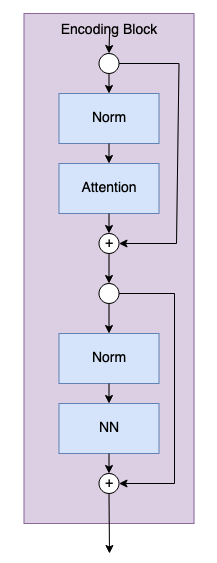

The code for an encoding block is below.

In [15]:
class Encoding(nn.Module):

    def __init__(self,
       dim: int,
       num_heads: int=1,
       hidden_chan_mul: float=4.,
       qkv_bias: bool=False,
       qk_scale: NoneFloat=None,
       act_layer=nn.GELU, 
       norm_layer=nn.LayerNorm):
        
        """ Encoding Block

            Args:
                dim (int): size of a single token
                num_heads(int): number of attention heads in MSA
                hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Define Layers
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim=dim,
                            chan=dim,
                            num_heads=num_heads,
                            qkv_bias=qkv_bias,
                            qk_scale=qk_scale)
        self.norm2 = norm_layer(dim)
        self.neuralnet = NeuralNet(in_chan=dim,
                                hidden_chan=int(dim*hidden_chan_mul),
                                out_chan=dim,
                                act_layer=act_layer)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.neuralnet(self.norm2(x))
        return x

The *num_heads*, *qkv_bias*, and *qk_scale* parameters define the *Attention* module components. A deep dive into attention for vision transformers is left for [another time](https://towardsdatascience.com/attention-for-vision-transformers-explained-70f83984c673).

The *hidden_chan_mul* and *act_layer* parameters define the *Neural Network* module components. The activation layer can be any `torch.nn.modules.activation`⁷ layer. We'll look more at the *Neural Network* module later.

The *norm_layer* can be chosen from any `torch.nn.modules.normalization`⁸ layer.

We'll now step through each blue block in the diagram and its accompanying code. We'll use 176 tokens of length 768. We'll use a batch size of 13 because it's prime and won't be confused for any of the other parameters. We'll use 4 attention heads because it evenly divides token length; however, you won't see the attention head dimension in the encoding block.

In [16]:
# Define an Input
num_tokens = 176
token_len = 768
batch = 13
heads = 4
x = torch.rand(batch, num_tokens, token_len)
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

# Define the Module
E = Encoding(dim=token_len, num_heads=heads, hidden_chan_mul=1.5, qkv_bias=False, qk_scale=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm)
E.eval();

Input dimensions are
	batchsize: 13 
	number of tokens: 176 
	token length: 768


Now, we'll pass through a norm layer and an *Attention* module. The *Attention* module in the encoding block is parameterized so that it don't change the token length. After the *Attention module*, we implement our first split connection.

In [17]:
y = E.norm1(x)
print('After norm, dimensions are\n\tbatchsize:', y.shape[0], '\n\tnumber of tokens:', y.shape[1], '\n\ttoken size:', y.shape[2])
y = E.attn(y)
print('After attention, dimensions are\n\tbatchsize:', y.shape[0], '\n\tnumber of tokens:', y.shape[1], '\n\ttoken size:', y.shape[2])
y = y + x
print('After split connection, dimensions are\n\tbatchsize:', y.shape[0], '\n\tnumber of tokens:', y.shape[1], '\n\ttoken size:', y.shape[2])

After norm, dimensions are
	batchsize: 13 
	number of tokens: 176 
	token size: 768
After attention, dimensions are
	batchsize: 13 
	number of tokens: 176 
	token size: 768
After split connection, dimensions are
	batchsize: 13 
	number of tokens: 176 
	token size: 768


Now, we pass through another norm layer, and then the *Neural Network* module. We finish with the second split connection.

In [18]:
z = E.norm2(y)
print('After norm, dimensions are\n\tbatchsize:', z.shape[0], '\n\tnumber of tokens:', z.shape[1], '\n\ttoken size:', z.shape[2])
z = E.neuralnet(z)
print('After neural net, dimensions are\n\tbatchsize:', z.shape[0], '\n\tnumber of tokens:', z.shape[1], '\n\ttoken size:', z.shape[2])
z = z + y
print('After split connection, dimensions are\n\tbatchsize:', z.shape[0], '\n\tnumber of tokens:', z.shape[1], '\n\ttoken size:', z.shape[2])

After norm, dimensions are
	batchsize: 13 
	number of tokens: 176 
	token size: 768
After neural net, dimensions are
	batchsize: 13 
	number of tokens: 176 
	token size: 768
After split connection, dimensions are
	batchsize: 13 
	number of tokens: 176 
	token size: 768


That's all for a single encoding block! Since the final dimensions are the same as the initial dimensions, the model can easily pass tokens through multiple encoding blocks, as set by the *depth* hyperparameter.

### Neural Network Module

The *Neural Network* (NN) module is a sub-component of the encoding block. The NN module is very simple, consisting of a fully-connected layer, an activation layer, and another fully-connected layer. The activation layer can be any `torch.nn.modules.activation`⁷ layer, which is passed as input to the module. The NN module can be configured to change the shape of an input, or to maintain the same shape. We're not going to step through this code, as neural networks are common in machine learning, and not the focus of this article. However, the code for the NN module is presented below.

In [19]:
class NeuralNet(nn.Module):
    def __init__(self,
       in_chan: int,
       hidden_chan: NoneFloat=None,
       out_chan: NoneFloat=None,
       act_layer = nn.GELU):
        """ Neural Network Module

            Args:
                in_chan (int): number of channels (features) at input
                hidden_chan (NoneFloat): number of channels (features) in the hidden layer;
                                        if None, number of channels in hidden layer is the same as the number of input channels
                out_chan (NoneFloat): number of channels (features) at output;
                                        if None, number of output channels is same as the number of input channels
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
        """

        super().__init__()

        ## Define Number of Channels
        hidden_chan = hidden_chan or in_chan
        out_chan = out_chan or in_chan

        ## Define Layers
        self.fc1 = nn.Linear(in_chan, hidden_chan)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_chan, out_chan)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

### Prediction Processing

After passing through the encoding blocks, the last thing the model must do is make a prediction. The "prediction processing" component of the ViT diagram is shown below.

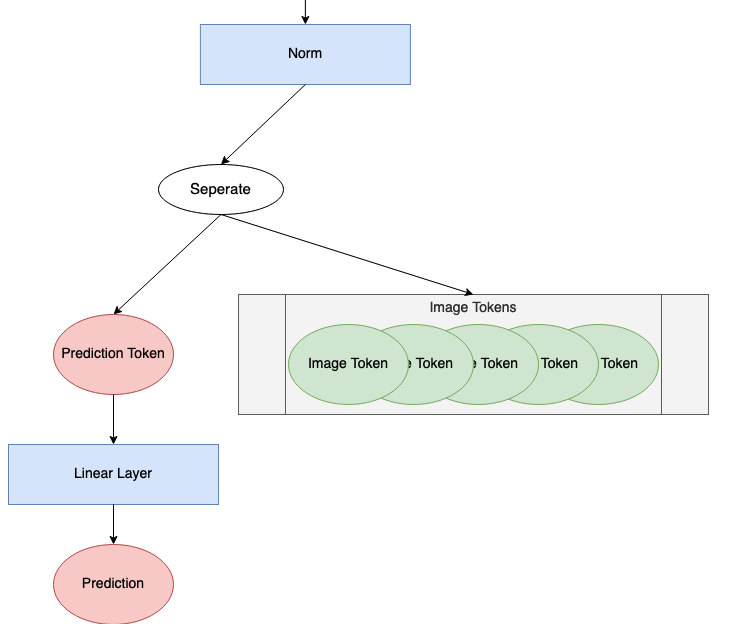

We're going to look at each step of this process. We'll continue with 176 tokens of length 768. We'll use a  batch size of 1 to illustrate how a single prediction is made. A batch size greater than 1 would be computing this prediction in parallel.

In [20]:
# Define an Input
num_tokens = 176
token_len = 768
batch = 1
x = torch.rand(batch, num_tokens, token_len)
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

Input dimensions are
	batchsize: 1 
	number of tokens: 176 
	token length: 768


First, all the tokens are passed through a norm layer.

In [21]:
norm = nn.LayerNorm(token_len)
x = norm(x)
print('After norm, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])

After norm, dimensions are
	batchsize: 1 
	number of tokens: 176 
	token size: 768


Next, we split off the prediction token from the rest of the tokens. Throughout the encoding block(s), the prediction token has become nonzero and gained information about our input image. We'll use only this prediction token to make a final prediction.

In [22]:
pred_token = x[:, 0]
print('Length of prediction token:', pred_token.shape[-1])

Length of prediction token: 768


Finally, the prediction token is passed through the *head* to make a prediction. The *head*, usually some variety of neural network, is varied based on the model. In *An Image is Worth 16x16 Words*², they use an MLP ([multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)) with one hidden layer during pretraining and a single linear layer during fine tuning. In *Tokens-to-Token ViT*³, they use a single linear layer as a head. This example proceeds with a single linear layer.

Note that the output shape of the head is set based on the parameters of the learning problem. For classification, it is typically a vector of length *number of classes* in a [one-hot encoding](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics). For regression, it would be any integer number of predicted parameters. This example will use an output shape of 1 to represent a single estimated regression value.

In [23]:
head = nn.Linear(token_len, 1)
pred = head(pred_token)
print('Length of prediction:', (pred.shape[0], pred.shape[1]))
print('Prediction:', float(pred))

Length of prediction: (1, 1)
Prediction: 1.7190196514129639


And that's all! The model has made a prediction!

## Complete Code

To create the complete ViT module, we use the *Patch Tokenization* module defined above and the *ViT Backbone* module. The *ViT Backbone* is defined below, and contains the *Token Processing*, *Encoding Blocks*, and *Prediction Processing* components.

In [24]:
class ViT_Backbone(nn.Module):
    def __init__(self,
                preds: int=1,
                token_len: int=768,
                num_heads: int=1,
                Encoding_hidden_chan_mul: float=4.,
                depth: int=12,
                qkv_bias=False,
                qk_scale=None,
                act_layer=nn.GELU,
                norm_layer=nn.LayerNorm):

        """ VisTransformer Backbone
            Args:
                preds (int): number of predictions to output
                token_len (int): length of a token
                num_heads(int): number of attention heads in MSA
                Encoding_hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component of the Encoding Module
                depth (int): number of encoding blocks in the model
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                 if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Defining Parameters
        self.num_heads = num_heads
        self.Encoding_hidden_chan_mul = Encoding_hidden_chan_mul
        self.depth = depth

        ## Defining Token Processing Components
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.token_len))
        self.pos_embed = nn.Parameter(data=get_sinusoid_encoding(num_tokens=self.num_tokens+1, token_len=self.token_len), requires_grad=False)

        ## Defining Encoding blocks
        self.blocks = nn.ModuleList([Encoding(dim = self.token_len, 
                                               num_heads = self.num_heads,
                                               hidden_chan_mul = self.Encoding_hidden_chan_mul,
                                               qkv_bias = qkv_bias,
                                               qk_scale = qk_scale,
                                               act_layer = act_layer,
                                               norm_layer = norm_layer)
             for i in range(self.depth)])

        ## Defining Prediction Processing
        self.norm = norm_layer(self.token_len)
        self.head = nn.Linear(self.token_len, preds)

        ## Make the class token sampled from a truncated normal distrobution 
        timm.layers.trunc_normal_(self.cls_token, std=.02)

    def forward(self, x):
        ## Assumes x is already tokenized

        ## Get Batch Size
        B = x.shape[0]
        ## Concatenate Class Token
        x = torch.cat((self.cls_token.expand(B, -1, -1), x), dim=1)
        ## Add Positional Embedding
        x = x + self.pos_embed
        ## Run Through Encoding Blocks
        for blk in self.blocks:
            x = blk(x)
        ## Take Norm
        x = self.norm(x)
        ## Make Prediction on Class Token
        x = self.head(x[:, 0])
        return x

From the *ViT Backbone* module, we can define the full ViT model.

In [25]:
class ViT_Model(nn.Module):
    def __init__(self,
                img_size: tuple[int, int, int]=(1, 400, 100),
                patch_size: int=50,
                token_len: int=768,
                preds: int=1,
                num_heads: int=1,
                Encoding_hidden_chan_mul: float=4.,
                depth: int=12,
                qkv_bias=False,
                qk_scale=None,
                act_layer=nn.GELU,
                norm_layer=nn.LayerNorm):

        """ VisTransformer Model
            Args:
                img_size (tuple[int, int, int]): size of input (channels, height, width)
                patch_size (int): the side length of a square patch
                token_len (int): desired length of an output token
                preds (int): number of predictions to output
                num_heads(int): number of attention heads in MSA
                Encoding_hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component of the Encoding Module
                depth (int): number of encoding blocks in the model
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """
        super().__init__()

        ## Defining Parameters
        self.img_size = img_size
        C, H, W = self.img_size
        self.patch_size = patch_size
        self.token_len = token_len
        self.num_heads = num_heads
        self.Encoding_hidden_chan_mul = Encoding_hidden_chan_mul
        self.depth = depth

        ## Defining Patch Embedding Module
        self.patch_tokens = Patch_Tokenization(img_size,
        patch_size,
        token_len)

        ## Defining ViT Backbone
        self.backbone = ViT_Backbone(preds,
                                    self.token_len,
                                    self.num_heads,
                                    self.Encoding_hidden_chan_mul,
                                    self.depth,
                                    qkv_bias,
                                    qk_scale,
                                    act_layer,
                                    norm_layer)
        ## Initialize the Weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """ Initialize the weights of the linear layers & the layernorms
        """
        ## For Linear Layers
        if isinstance(m, nn.Linear):
            ## Weights are initialized from a truncated normal distrobution
            timm.layers.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                ## If bias is present, bias is initialized at zero
                nn.init.constant_(m.bias, 0)
        ## For Layernorm Layers
        elif isinstance(m, nn.LayerNorm):
            ## Weights are initialized at one
            nn.init.constant_(m.weight, 1.0)
            ## Bias is initialized at zero
            nn.init.constant_(m.bias, 0)

    @torch.jit.ignore ##Tell pytorch to not compile as TorchScript
    def no_weight_decay(self):
        """ Used in Optimizer to ignore weight decay in the class token
        """
        return {'cls_token'}

    def forward(self, x):
        x = self.patch_tokens(x)
        x = self.backbone(x)
        return x

In the ViT Model, the *img_size*, *patch_size*, and *token_len* define the Patch Tokenization module.

The *num_heads*, *Encoding_hidden_channel_mul*, *qkv_bias*, *qk_scale*, and *act_layer* parameters define the *Encoding Block* modules. The *act_layer* can be any `torch.nn.modules.activation`⁷ layer.  The *depth* parameter determines how many encoding blocks are in the model. 

The *norm_layer* parameter sets the norm for both within and outside of the *Encoding Block* modules. It can be chosen from any `torch.nn.modules.normalization`⁸ layer.

The *\_init_weights* method comes from the T2T-ViT³ code. This method could be deleted to initiate all learned weights and biases randomly. As implemented, the weights of linear layers are initialized as a truncated normal distribution; the biases of linear layers are initialized as zero; the weights of normalization layers are initialized as one; the biases of normalization layers are initialized as zero.

## Conclusion

Now, you can go forth and train ViT models with a deep understanding of their mechanics! Below is a list of places to download code for ViT models. Some of them allow for more modifications of the model than others. Happy transforming!

 - [GitHub Repository](https://github.com/lanl/vision_transformers_explained) for this Article Series
 - [GitHub Repository](https://github.com/google-research/vision_transformer) for An Image is Worth 16x16 Words²
     - Contains pretrained models and code for fine-tuning; does not contain model definitions
 - ViT as implemented in [PyTorch Image Models](https://github.com/huggingface/pytorch-image-models) (`timm`)⁹
     - `timm.create_model('vit_base_patch16_224', pretrained=True)`
 - Phil Wang's `vit-pytorch` [package](https://github.com/lucidrains/vit-pytorch)
 
This article was approved for release by Los Alamos National Laboratory as LA-UR-23–33876. The associated code was approved for a BSD-3 open source license under O#4693.

### Further Reading

To learn more about transformers in NLP contexts, see
 - Transformers Explained Visually Part 1 Overview of Functionality: https://towardsdatascience.com/transformers-explained-visually-part-1-overview-of-functionality-95a6dd460452
 - Transformers Explained Visually Part 2 How it Works, Step by Step: https://towardsdatascience.com/transformers-explained-visually-part-2-how-it-works-step-by-step-b49fa4a64f34

For a video lecture broadly about vision transformers, see
 - Vision Transformer and its Applications: https://youtu.be/hPb6A92LROc?si=GaGYiZoyDg0PcdSP

### Citations

[1] Vaswani et al (2017). *Attention Is All You Need*. https://doi.org/10.48550/arXiv.1706.03762

[2] Dosovitskiy et al (2020). *An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale*. https://doi.org/10.48550/arXiv.2010.11929

[3] Yuan et al (2021). *Tokens-to-Token ViT: Training Vision Transformers from Scratch on ImageNet*. https://doi.org/10.48550/arXiv.2101.11986
 - GitHub code: https://github.com/yitu-opensource/T2T-ViT

[4] Luis Zuno (@ansimuz). *Mountain at Dusk Background*. License CC0: https://opengameart.org/content/mountain-at-dusk-background

[5] PyTorch. *Unfold*. https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html#torch.nn.Unfold

[6] PyTorch. *Unsqueeze*. https://pytorch.org/docs/stable/generated/torch.unsqueeze.html#torch.unsqueeze

[7] PyTorch. *Non-linear Activation (weighted sum, nonlinearity)*. https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

[8] PyTorch. *Normalization Layers*. https://pytorch.org/docs/stable/nn.html#normalization-layers

[9] Ross Wightman. P*yTorch Image Models*. https://github.com/huggingface/pytorch-image-models